In [1]:
%cd /home/david/Desktop/antenna_arrays/

/home/david/Desktop/antenna_arrays


In [2]:
import torch
import numpy
from utils.util import *
from main import *
from torch.utils.data import DataLoader
import torch.nn as nn
from antenna_array_conversion.true_function import *
import antenna_array_conversion.torch_function as top

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NN2(2048, 1, 8, 8, nn.ReLU)
model.load_state_dict(torch.load('weights/NN2_CostScaled_8_8_ReLU.pth'))

<All keys matched successfully>

In [4]:
## smaller scale
given_shapes = pd.read_csv('top_10_arrays.csv')
dataloader = DataLoader(AntDataset(given_shapes.values))

In [5]:
ParamsArray = top.InitializeParamsArray(device = device)

In [15]:
def pen(x):
    if x <= 0.51:
        return torch.tensor([float('inf')])
    return torch.log(torch.tensor((1/(x-0.5))))

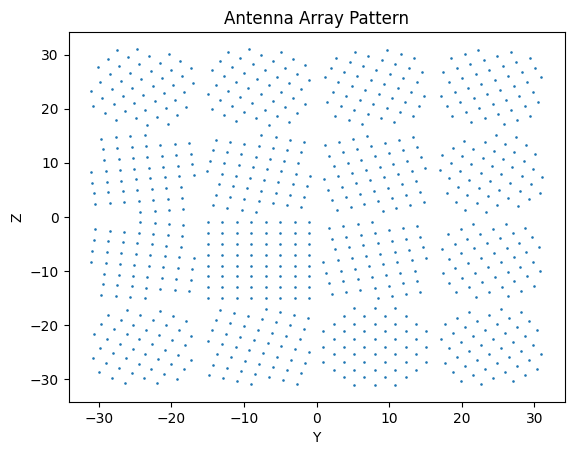

Number of antennas: 812.0
True Cost: -40463.984375
Predicted Cost: tensor([[-2.7861]], grad_fn=<AddmmBackward0>)
Early Stop on 13325


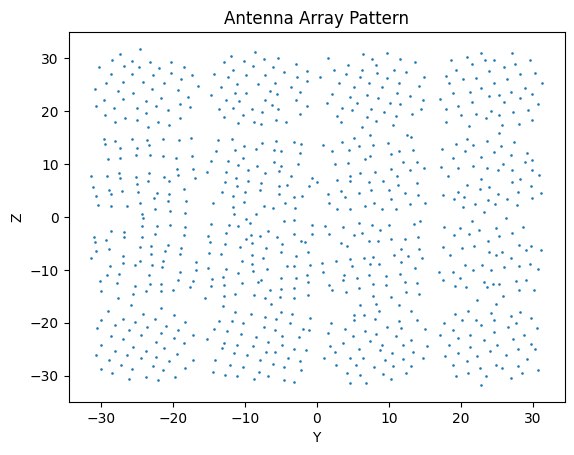

Number of antennas: 812.0
True Cost: -60841.07421875
Predicted Cost: tensor([[-5.1466]], grad_fn=<AddmmBackward0>)
Minimum Distance: 0.50006103515625


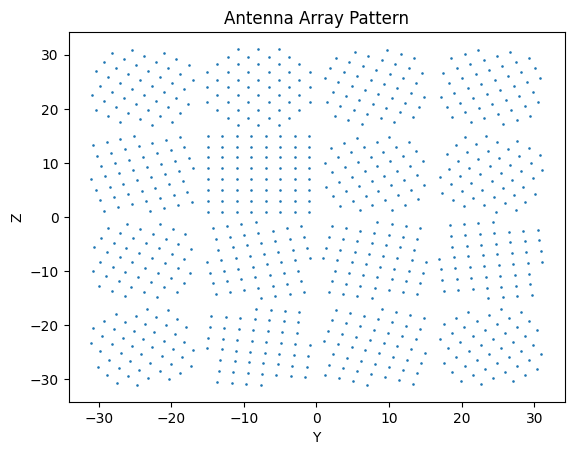

Number of antennas: 812.0
True Cost: -39931.296875
Predicted Cost: tensor([[-2.6941]], grad_fn=<AddmmBackward0>)


KeyboardInterrupt: 

In [16]:
for ants, c in dataloader:
    y,z = yz_split(ants.squeeze())
    show_arrays(ants)
    print(f'Number of antennas: {torch.count_nonzero(ants)/2}')
    print(f'True Cost: {top.CostFunArray(y,z, ParamsArray, device)}')
    print(f'Predicted Cost: {model(ants)}')
    
    optimized_ants = gradient_w_pen(model, ants, 0.01, 1, pen, iters=100_000)
    y,z = yz_split(optimized_ants.squeeze())
    show_arrays(optimized_ants)
    print(f'Number of antennas: {torch.count_nonzero(optimized_ants)/2}')
    print(f'True Cost: {top.CostFunArray(y,z, ParamsArray, device)}')
    print(f'Predicted Cost: {model(optimized_ants)}')
    print(f'Minimum Distance: {calculate_min_distance(optimized_ants)}')

## Corrective Step

In [17]:
def enforce_minimum_distance(ants, min_dist=0.5):
    """
    Adjusts positions of antennas in `ants` tensor to ensure that all pairs satisfy a minimum distance `min_dist`.
    """
    n_ants = ants.size(0)
    for i in range(n_ants):
        for j in range(i + 1, n_ants):
            dist = torch.norm(ants[i] - ants[j])
            if dist < min_dist:
                # Calculate the midpoint and the required adjustment
                midpoint = (ants[i] + ants[j]) / 2
                direction = (ants[j] - ants[i]) / dist
                adjustment = (min_dist - dist) / 2
                
                # Apply the adjustment
                ants[i] -= adjustment * direction
                ants[j] += adjustment * direction
    return ants


In [19]:
def penalty(dist, min_dist=0.5, steepness=1e6):
    # Apply a steep penalty for distances near or below the threshold
    return torch.where(dist <= min_dist, steepness, 0.0)

In [18]:
def gradient_w_pen(model, ants, lr, eps=1e-6, penalty=lambda x: 0, iters=100):
    model.eval()
    ants = ants.clone().requires_grad_()
    for i in range(iters):
        if ants.grad is not None:
            ants.grad.zero_()
        output = model(ants)
        dist = calculate_min_distance(ants)
        cost = output + (eps * penalty(dist))
        cost.backward()

        with torch.no_grad():
            last = ants.clone()
            ants -= (lr * ants.grad)
            
            # Check and enforce the minimum distance constraint after each update
            if calculate_min_distance(ants) < 0.5:
                ants = enforce_minimum_distance(ants)
                
    return ants


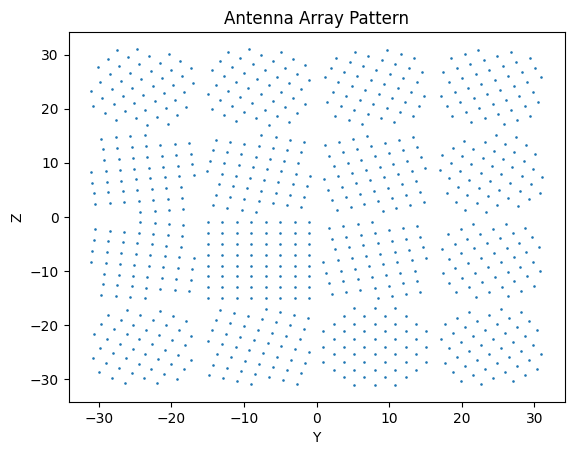

Number of antennas: 812.0
True Cost: -40463.984375
Predicted Cost: tensor([[-2.7861]], grad_fn=<AddmmBackward0>)


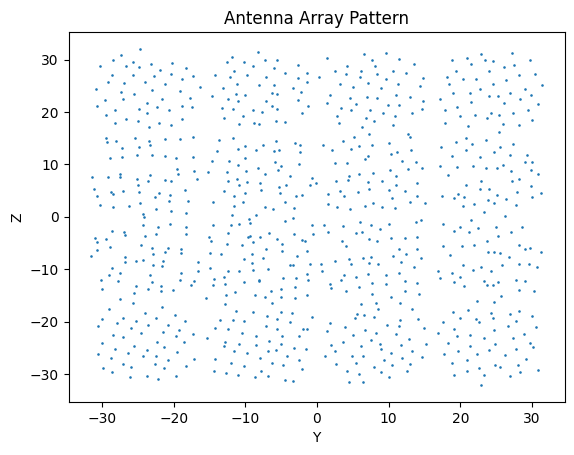

Number of antennas: 812.0
True Cost: -63533.60546875
Predicted Cost: tensor([[-5.6213]], grad_fn=<AddmmBackward0>)
Minimum Distance: 0.16801416873931885


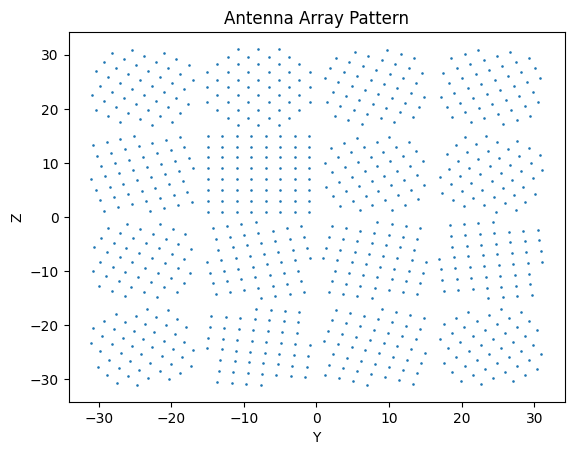

Number of antennas: 812.0
True Cost: -39931.296875
Predicted Cost: tensor([[-2.6941]], grad_fn=<AddmmBackward0>)


KeyboardInterrupt: 

In [29]:
import torch

def calculate_pairwise_distances(ants, padding_value=0):
    # Exclude padding values from distance calculation
    valid_ants = ants[ants != padding_value]
    dists = torch.cdist(valid_ants.unsqueeze(0), valid_ants.unsqueeze(0))
    # Adding large value to diagonal removed since we're now only considering valid ants
    return dists.squeeze()

def apply_penalty_to_all_pairs(dists, threshold=0.5, steepness=1e6):
    # Apply penalties for distances below the threshold
    penalties = torch.where(dists < threshold, steepness, torch.tensor(0.0, device=dists.device))
    total_penalty = penalties.sum()
    return total_penalty

def gradient_w_pen(model, ants, lr, eps=1e-6, threshold=0.5, steepness=1e6, iters=100):
    model.eval()
    ants = ants.clone().detach().requires_grad_(True)
    
    # Identify padding and non-padding indices
    padding_mask = (ants == 0)
    non_padding_mask = (ants != 0)
    
    for i in range(iters):
        if ants.grad is not None:
            ants.grad.zero_()
        
        output = model(ants.unsqueeze(0))  # Assuming model expects batch dimension
        dists = calculate_pairwise_distances(ants[non_padding_mask])
        penalty = apply_penalty_to_all_pairs(dists, threshold, steepness)
        cost = output + (eps * penalty)
        
        cost.backward()
        
        with torch.no_grad():
            # Update only non-padding values
            update_step = lr * ants.grad * non_padding_mask.float()
            ants -= update_step
            
    return ants

# Note: You might need to adjust the calculation and application of the padding mask depending on the exact structure of your `ants` tensor.


for ants, c in dataloader:
    y,z = yz_split(ants.squeeze())
    show_arrays(ants)
    print(f'Number of antennas: {torch.count_nonzero(ants)/2}')
    print(f'True Cost: {top.CostFunArray(y,z, ParamsArray, device)}')
    print(f'Predicted Cost: {model(ants)}')
    
    optimized_ants = gradient_w_pen(model, ants, 0.01, 1, threshold=0.5, steepness=1e9, iters=20_000)
    y,z = yz_split(optimized_ants.squeeze())
    show_arrays(optimized_ants)
    print(f'Number of antennas: {torch.count_nonzero(optimized_ants)/2}')
    print(f'True Cost: {top.CostFunArray(y,z, ParamsArray, device)}')
    print(f'Predicted Cost: {model(optimized_ants)}')
    print(f'Minimum Distance: {calculate_min_distance(optimized_ants)}')

## With Custom Loss and built-in optimizer

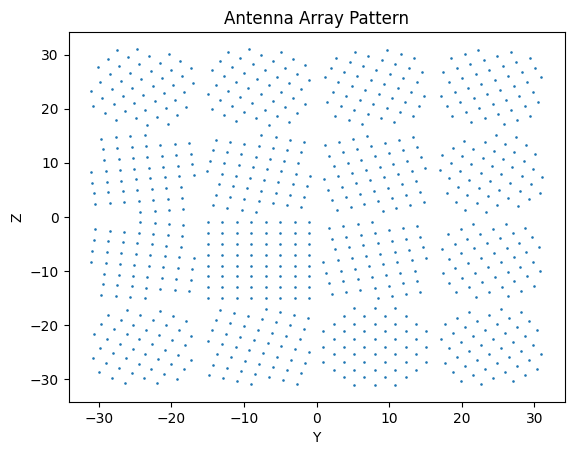

Number of antennas: 812.0
True Cost: -40463.984375
Predicted Cost: tensor([[-2.7861]], grad_fn=<AddmmBackward0>)


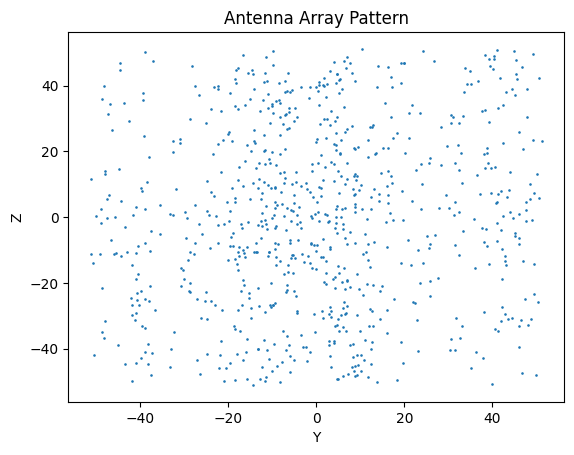

Number of antennas: 812.0
True Cost: -64699.703125
Predicted Cost: tensor([[-67.4947]], grad_fn=<AddmmBackward0>)
Minimum Distance: 0.046875


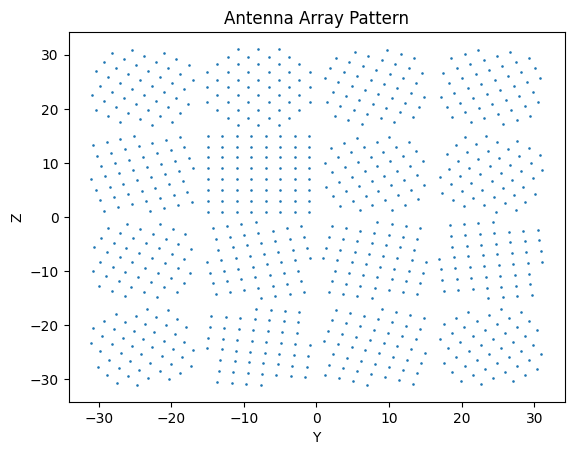

Number of antennas: 812.0
True Cost: -39931.296875
Predicted Cost: tensor([[-2.6941]], grad_fn=<AddmmBackward0>)


KeyboardInterrupt: 

In [36]:
def reset_padding(tensor, padding_mask):
    # tensor: the tensor to be adjusted
    # padding_mask: a Boolean tensor of the same shape as tensor, where True indicates padding that should be reset to zero
    with torch.no_grad():
        tensor[padding_mask] = 0

def penalty(ants, min_dist=0.5, steepness=1e6):
    # Apply a steep penalty for distances near or below the threshold
    return apply_penalty_to_all_pairs(calculate_pairwise_distances(ants))

def calculate_pairwise_distances(ants, padding_value=0):
    # Exclude padding values from distance calculation
    valid_ants = ants[ants != padding_value]
    dists = torch.cdist(valid_ants.unsqueeze(0), valid_ants.unsqueeze(0))
    # Adding large value to diagonal removed since we're now only considering valid ants
    return dists.squeeze()

def apply_penalty_to_all_pairs(dists, threshold=0.5, steepness=1e6):
    # Apply penalties for distances below the threshold
    penalties = torch.where(dists <= threshold, steepness, torch.tensor(0, device=dists.device))
    total_penalty = penalties.sum()
    return total_penalty

def loss(cost, ants, pen_func, w=1e6):
    return cost +  w *pen_func(ants)

def optimize_ants(model, ants_input, loss_func, optimizer_class, iters, lr=0.001):
    ants = ants_input.clone().detach().requires_grad_(True)  # Ensure ants is a clone and tracks gradients
    padding_mask = (ants == 0)
    opt = optimizer_class([ants], lr=lr)  # Initialize the optimizer correctly
    
    for it in range(iters):
        opt.zero_grad()
        model_output = model(ants)
        l = loss_func(model_output, ants, penalty)  # Make sure the loss function is called correctly
        l.backward()
        opt.step()  # Call step on the correct optimizer instance
        reset_padding(ants, padding_mask)  # Apply padding reset correctly
    
    return ants  # Return the optimized tensor

        
for ants, c in dataloader:
    y,z = yz_split(ants.squeeze())
    show_arrays(ants)
    print(f'Number of antennas: {torch.count_nonzero(ants)/2}')
    print(f'True Cost: {top.CostFunArray(y,z, ParamsArray, device)}')
    print(f'Predicted Cost: {model(ants)}')
    
    optimized_ants = optimize_ants(model, ants, loss, optim.Adam, iters = 20_000)
    y,z = yz_split(optimized_ants.squeeze())
    show_arrays(optimized_ants)
    print(f'Number of antennas: {torch.count_nonzero(optimized_ants)/2}')
    print(f'True Cost: {top.CostFunArray(y,z, ParamsArray, device)}')
    print(f'Predicted Cost: {model(optimized_ants)}')
    print(f'Minimum Distance: {calculate_min_distance(optimized_ants)}')

In [6]:
def optimize_ants(model, ants_input, optimizer_class, iters, lr=0.001):
    ants = ants_input.clone().detach().requires_grad_(True)  # Ensure ants is a clone and tracks gradients
    padding_mask = (ants == 0)
    opt = optimizer_class([ants], lr=lr)  # Initialize the optimizer correctly
    
    for it in range(iters):
        last = ants.clone()
        opt.zero_grad()
        model_output = model(ants)
        model_output.backward()  # Make sure the loss function is called correctly
        # l.backward()
        opt.step()  # Call step on the correct optimizer instance
        reset_padding(ants, padding_mask)  # Apply padding reset correctly
        if calculate_min_distance(ants) < 0.5:
            # print('Early Stop')
            return last
    return ants  # Return the optimized tensor


In [8]:
import pandas as pd
import os

def save_tensor_as_csv(tensor, directory, filename):
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Convert the tensor to a DataFrame and save it
    df = pd.DataFrame(tensor.clone().detach().numpy())
    filepath = os.path.join(directory, filename)
    df.to_csv(filepath, header=False, index=False)


figures_dir = '/home/david/Desktop/antenna_arrays/opt_no_pen_heat'
results_df = pd.DataFrame(columns=["Antenna Configuration", "True Cost Before", "Predicted Cost Before", 
                                   "True Cost After", "Predicted Cost After", "Minimum Distance After"])

for i, (ants, c) in enumerate(dataloader):
    y, z = yz_split(ants.squeeze())
    true_cost_before = top.CostFunArray(y, z, ParamsArray, device)
    predicted_cost_before = model(ants).item()  # Assuming model(ants) returns a tensor
    
    # save shape
    shape_dir = f'{figures_dir}/shape{i}'
    opt_shape_dir = f'{figures_dir}/opt_shape{i}'
    
    save_tensor_as_csv(y, shape_dir, f'yant{i}.csv')
    save_tensor_as_csv(z, shape_dir, f'zant{i}.csv')
    
    # Save the initial figure
    initial_title = f"Initial Configuration {i}"
    show_arrays(ants, initial_title, figures_dir)
    
    # Perform optimization
    optimized_ants = optimize_ants(model, ants, optim.Adam, iters = 1_000)
    y, z = yz_split(optimized_ants.squeeze())
    true_cost_after = top.CostFunArray(y, z, ParamsArray, device)
    predicted_cost_after = model(optimized_ants).item()
    min_distance_after = calculate_min_distance(optimized_ants)
    
    # save opt
    save_tensor_as_csv(y, opt_shape_dir, f'yant{i}.csv')
    save_tensor_as_csv(z, opt_shape_dir, f'zant{i}.csv')
    
    # Save the optimized figure
    optimized_title = f"Optimized Configuration {i}"
    show_arrays(optimized_ants, optimized_title, figures_dir)
    
    # Record the results
    results_df = results_df.append({
        "Antenna Configuration": i,
        "True Cost Before": true_cost_before,
        "Predicted Cost Before": predicted_cost_before,
        "True Cost After": true_cost_after,
        "Predicted Cost After": predicted_cost_after,
        "Minimum Distance After": min_distance_after
    }, ignore_index=True)

# Save the DataFrame to CSV
results_df.to_csv(figures_dir + '/results.csv', index=False)

/tmp/ipykernel_1913492/1027367666.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_1913492/1027367666.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_1913492/1027367666.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_1913492/1027367666.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_1913492/1027367666.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

In [ ]:
def optimize_ants(model, ants_input, loss_func, optimizer_class, iters, lr=0.001):
    ants = ants_input.clone().detach().requires_grad_(True)  # Ensure ants is a clone and tracks gradients
    padding_mask = (ants == 0)
    opt = optimizer_class([ants], lr=lr)  # Initialize the optimizer correctly
    
    for it in range(iters):
        last = ants.clone()
        opt.zero_grad()
        model_output = model(ants)
        loss = loss_func(model_output, ants)
        loss.backward()
        opt.step()  # Call step on the correct optimizer instance
        reset_padding(ants, padding_mask)  # Apply padding reset correctly
        if calculate_min_distance(ants) < 0.5:
            print('Early Stop')
            return last
    return ants  # Return the optimized tensor

        
for ants, c in dataloader:
    y,z = yz_split(ants.squeeze())
    show_arrays(ants)
    print(f'Number of antennas: {torch.count_nonzero(ants)/2}')
    print(f'True Cost: {top.CostFunArray(y,z, ParamsArray, device)}')
    print(f'Predicted Cost: {model(ants)}')
    
    optimized_ants = optimize_ants(model, ants, loss, optim.Adam, iters = 20_000)
    y,z = yz_split(optimized_ants.squeeze())
    show_arrays(optimized_ants)
    print(f'Number of antennas: {torch.count_nonzero(optimized_ants)/2}')
    print(f'True Cost: {top.CostFunArray(y,z, ParamsArray, device)}')
    print(f'Predicted Cost: {model(optimized_ants)}')
    print(f'Minimum Distance: {calculate_min_distance(optimized_ants)}')

## Custom Loss with built-in optimizer

In [9]:
def loss_func(ant_cost, ants, threshold = 0.5, epsilon = 1e-6, damp = 1e2):
    # calculate the dist and custom penalty
    if ants.shape[0] == 1:
        ants = ants.squeeze(0)
    antennas = torch.transpose(torch.reshape(ants, (2,1024)), 0, 1)    
    # Identify and exclude padding antennas 
    non_padding_mask = torch.logical_not((antennas[:, 0] == 0) & (antennas[:, 1] == 0))
    valid_antennas = antennas[non_padding_mask]
    
    dists = torch.cdist(valid_antennas, valid_antennas)
    penalty_matrix = torch.zeros_like(dists)
    
    penalty_matrix[dists < threshold] = float('inf') # maybe change to high constant
    valid_mask = (dists >= threshold) & (dists != 0)
    penalty_matrix[valid_mask] = epsilon * torch.log(1/(dists[valid_mask] - threshold))
    penalty_matrix.fill_diagonal_(0)
    penalty = penalty_matrix.sum()
    return ant_cost + damp * penalty

def reset_padding(tensor, padding_mask):
    # tensor: the tensor to be adjusted
    # padding_mask: a Boolean tensor of the same shape as tensor, where True indicates padding that should be reset to zero
    with torch.no_grad():
        tensor[padding_mask] = 0
        
def optimize_ants_pen(model, ants_input, optimizer_class, iters, lr=0.001, loss_fn = lambda x,y: x):
    ants = ants_input.clone().detach().requires_grad_(True)  # Ensure ants is a clone and tracks gradients
    padding_mask = (ants == 0)
    opt = optimizer_class([ants], lr=lr)  # Initialize the optimizer correctly
    
    for it in range(iters):
        last = ants.clone()
        opt.zero_grad()
        model_output = model(ants)
        loss = loss_fn(model_output, ants) # default only returns the model_output
        loss.backward()
        # model_output.backward()  # Make sure the loss function is called correctly
        opt.step()  # Call step on the correct optimizer instance
        reset_padding(ants, padding_mask)  # Apply padding reset correctly
        if calculate_min_distance(ants) < 0.5:
            print(f'Early Stop at {it}')
            return last
    return ants  # Return the optimized tensor

In [9]:
figures_dir = '/home/david/Desktop/antenna_arrays/opt_w_penalty'
results_df = pd.DataFrame(columns=["Antenna Configuration", "True Cost Before", "Predicted Cost Before", 
                                   "True Cost After", "Predicted Cost After", "Minimum Distance After"])

for i, (ants, c) in enumerate(dataloader):
    y, z = yz_split(ants.squeeze())
    true_cost_before = top.CostFunArray(y, z, ParamsArray, device)
    predicted_cost_before = model(ants).item()  # Assuming model(ants) returns a tensor
    
    # Save the initial figure
    initial_title = f"Initial Configuration {i}"
    show_arrays(ants, initial_title, figures_dir)
    
    # Perform optimization
    optimized_ants = optimize_ants_pen(model, ants, optim.Adam, iters = 1_000, loss_fn=loss_func)
    y, z = yz_split(optimized_ants.squeeze())
    true_cost_after = top.CostFunArray(y, z, ParamsArray, device)
    predicted_cost_after = model(optimized_ants).item()
    min_distance_after = calculate_min_distance(optimized_ants)
    
    # Save the optimized figure
    optimized_title = f"Optimized Configuration {i}"
    show_arrays(optimized_ants, optimized_title, figures_dir)
    
    # Record the results
    results_df = results_df.append({
        "Antenna Configuration": i,
        "True Cost Before": true_cost_before,
        "Predicted Cost Before": predicted_cost_before,
        "True Cost After": true_cost_after,
        "Predicted Cost After": predicted_cost_after,
        "Minimum Distance After": min_distance_after
    }, ignore_index=True)

# Save the DataFrame to CSV
results_df.to_csv(figures_dir + '/results.csv', index=False)

/tmp/ipykernel_1904474/17026254.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_1904474/17026254.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_1904474/17026254.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_1904474/17026254.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_1904474/17026254.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [10]:
# look at the tables
results_no_pen = pd.read_csv('opt_no_penalty/results.csv')
results_w_pen = pd.read_csv('opt_w_penalty/results.csv')

In [11]:
results_no_pen

,Antenna Configuration,True Cost Before,Predicted Cost Before,True Cost After,Predicted Cost After,Minimum Distance After
0,0.0,-40463.984375,-2.786141,-59259.425781,-4.959236,0.500915
1,1.0,-39931.296875,-2.694126,-71463.429688,-4.442347,0.500915
2,2.0,-39767.265625,-2.763090,-68767.703125,-4.347484,0.501219
3,3.0,-39472.406250,-2.822223,-73567.992188,-4.615893,0.501813
4,4.0,-39431.636719,-2.898480,-74720.593750,-4.533347,0.501037
5,5.0,-39383.218750,-2.764841,-69484.531250,-4.323932,0.501341
6,6.0,-39036.941406,-2.778366,-71489.812500,-4.525676,0.501508
7,7.0,-38702.128906,-2.467460,-69160.226562,-4.422828,0.500244
8,8.0,-38690.566406,-2.725356,-67744.539062,-4.309757,0.500976
9,9.0,-38600.695312,-2.649307,-62319.699219,-4.247998,0.501706


In [12]:
results_w_pen

,Antenna Configuration,True Cost Before,Predicted Cost Before,True Cost After,Predicted Cost After,Minimum Distance After
0,0.0,-40463.984375,-2.786141,-62707.027344,-5.638664,0.545016
1,1.0,-39931.296875,-2.694126,-62414.316406,-4.866222,0.537589
2,2.0,-39767.265625,-2.763090,-61536.171875,-4.870079,0.537006
3,3.0,-39472.406250,-2.822223,-65322.542969,-4.938832,0.546107
4,4.0,-39431.636719,-2.898480,-64732.187500,-5.063077,0.548630
5,5.0,-39383.218750,-2.764841,-57236.769531,-4.888398,0.548588
6,6.0,-39036.941406,-2.778366,-57222.968750,-4.864979,0.553090
7,7.0,-38702.128906,-2.467460,-60443.722656,-4.829121,0.576010
8,8.0,-38690.566406,-2.725356,-55638.527344,-4.822965,0.535805
9,9.0,-38600.695312,-2.649307,-51070.156250,-4.804883,0.551750


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def compare_true_costs(results_no_pen, results_w_pen):
    # Increase figure size for better visibility
    plt.figure(figsize=(12, 8))  # Width, height in inches
    
    n_configs = len(results_no_pen)
    configs = range(n_configs)  # Simple range for x-axis positions
    
    # Width of the bars
    width = 0.2
    
    # Calculating positions for each set of bars
    positions_no_pen_before = np.array(configs) - width
    positions_no_pen_after = np.array(configs)
    positions_w_pen_after = np.array(configs) + width
    
    # Plotting "True Cost Before" and "True Cost After" for results_no_pen
    plt.bar(positions_no_pen_before, results_no_pen["True Cost Before"], width=width, label='True Cost Before (No Pen)')
    plt.bar(positions_no_pen_after, results_no_pen["True Cost After"], width=width, label='True Cost After (No Pen)')
    
    # Plotting "True Cost After" for results_w_pen for comparison
    plt.bar(positions_w_pen_after, results_w_pen["True Cost After"], width=width, label='True Cost After (W/ Pen)')
    
    # Adding labels, title
    plt.xlabel('Antenna Configuration')
    plt.ylabel('True Cost')
    plt.title('Comparison of True Cost Before vs. After Optimization')
    
    # Setting x-ticks
    plt.xticks(configs, results_no_pen["Antenna Configuration"], rotation=45)
    
    # Adjusting the legend position to 'upper left' outside the plot area
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()


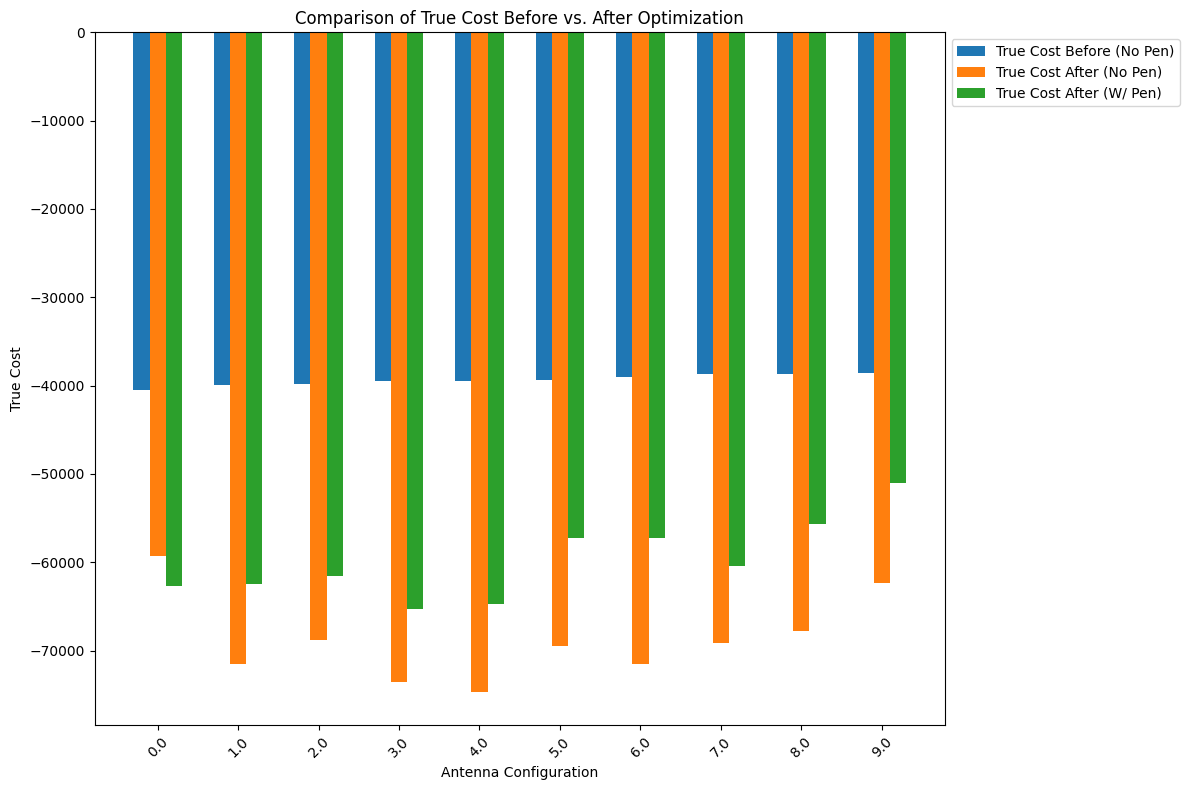

In [18]:
compare_true_costs(results_no_pen, results_w_pen)

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def compare_minimum_distances(results_no_pen, results_w_pen):
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility

    n_configs = len(results_no_pen)
    configs = range(n_configs)  # Simple range for x-axis positions

    # Width of the bars
    width = 0.35

    # Calculating positions for each set of bars
    positions_no_pen = np.array(configs) - width / 2
    positions_w_pen = np.array(configs) + width / 2

    # Plotting "Minimum Distance After" for both results_no_pen and results_w_pen
    plt.bar(positions_no_pen, results_no_pen["Minimum Distance After"], width=width, label='Min Distance After (No Pen)', color='skyblue')
    plt.bar(positions_w_pen, results_w_pen["Minimum Distance After"], width=width, label='Min Distance After (W/ Pen)', color='orange')

    # Adding labels, title
    plt.xlabel('Antenna Configuration')
    plt.ylabel('Minimum Distance After')
    plt.title('Comparison of Minimum Distance After Optimization')
    
    # Setting x-ticks
    plt.xticks(configs, results_no_pen["Antenna Configuration"], rotation=45)
    
    # Adjusting the legend position to avoid covering the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()


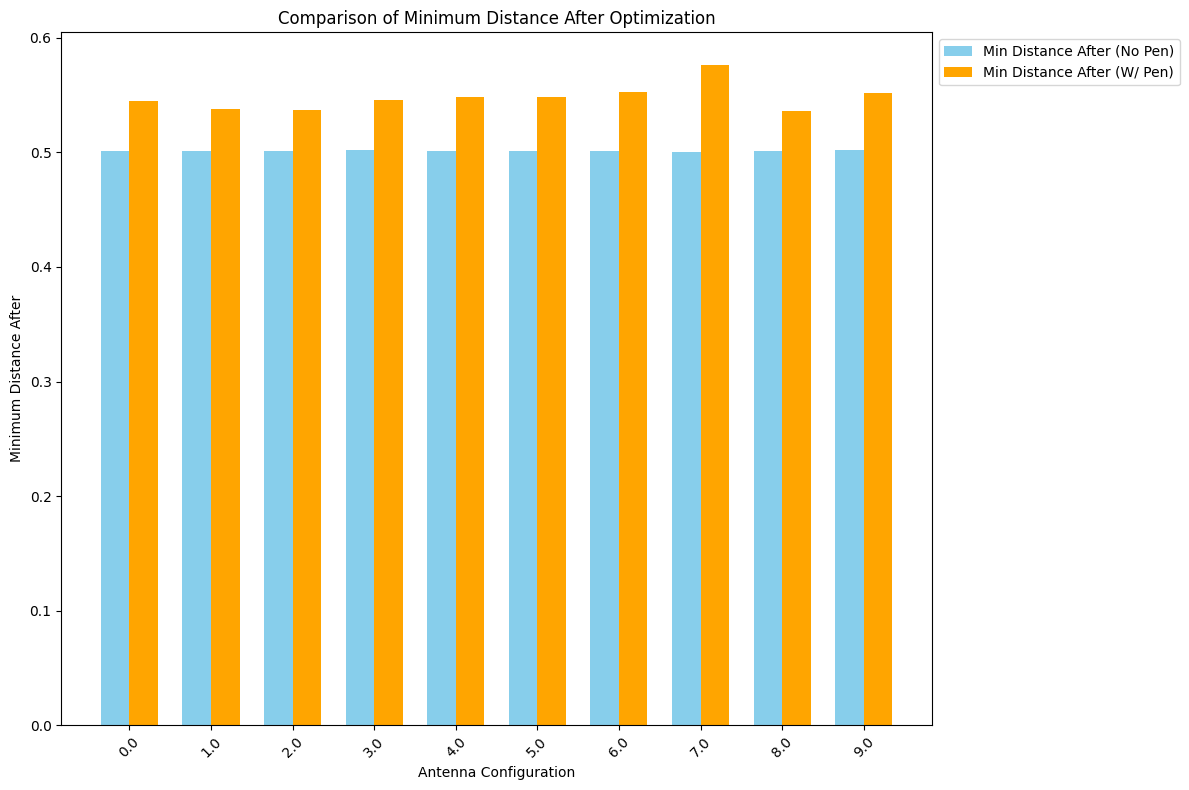

In [20]:
compare_minimum_distances(results_no_pen, results_w_pen)